In [ ]:
''' Global parameters '''

tiling = True 
# False: dataloader just resizes images. In test phase there's upscaling (bad performance).
# True:  dataloader random crops images for training and validation datasets. In test phase there's the correct reconstruction of each image, with overlap.

# Training/Validation dataset split proportion
train_valid_split = 0.8

# Batch size
bs = 16

# Img shape (both for tiling = True/False)
img_h = 256
img_w = 256

In [ ]:
import os
import math
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from google.colab import drive
from datetime import datetime
import matplotlib.pyplot as plt 

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(seed = SEED)

cwd = os.getcwd()

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Augmentation

In [ ]:
# Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation:
    images_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        cval=0,
                                        rescale=1./255)

    masks_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        cval=0)
    
else:
  images_data_gen = ImageDataGenerator(rescale=1./255)
  masks_data_gen = ImageDataGenerator()

#Data Loading

In [ ]:
dataset_dir = os.path.join(cwd, '/content/drive/My Drive/weeds_localizator/Development_Dataset/')
training_dir = os.path.join(dataset_dir, 'Training')

# Function to import a specific dataset
def import_specific_dataset(dataset_name, vegetable_name):

  # take the path of the vegetable
  vegetable_dir = training_dir + '/' + dataset_name + '/' + vegetable_name

  # path of the image
  images_dir = vegetable_dir + '/Images'
  images = []
  masks = []

  for filename in os.listdir(images_dir):
    image_path = images_dir + '/' + filename
    images.append(image_path)
    mask_path = vegetable_dir + '/Masks/' + filename.split(".")[-2] + '.png'
    masks.append(mask_path)
  df = pd.DataFrame(zip(images, masks))
  return df

In [ ]:
# Choose which dataset to include

df1 = import_specific_dataset('Bipbip', 'Haricot')
#df2 = import_specific_dataset('Bipbip', 'Mais')
df3 = import_specific_dataset('Weedelec', 'Haricot')
#df4 = import_specific_dataset('Weedelec', 'Mais')
df5 = import_specific_dataset('Roseau', 'Haricot')
#df6 = import_specific_dataset('Roseau', 'Mais')

# 'Pead' was exluded because it shows very different images with respect to other datasets 

df = pd.concat([df1, df3, df5]) # df is the union of all chosen datasets

In [ ]:
# Shuffle

df = df.sample(frac=1).reset_index(drop=True)


# Training/Validation Split

train_dataFrame = pd.DataFrame()
valid_dataFrame = pd.DataFrame()

train_dataFrame = train_dataFrame.append(df.head(math.floor(len(df.index) * train_valid_split)), ignore_index=True)
valid_dataFrame = valid_dataFrame.append(df.tail(len(df)-math.floor(len(df.index) * train_valid_split)), ignore_index=True)

train_images_dataframe = train_dataFrame[0]
train_masks_dataframe = train_dataFrame[1]
valid_images_dataframe = valid_dataFrame[0]
valid_masks_dataframe = valid_dataFrame[1]

In [ ]:
def read_rgb_mask(img_path):
    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    
    # In the original version it was: 
    # new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] 
    # Here's the corrected one:
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0  # Other vegetation, transform it into background
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1 # Crop
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2   # Weed

    return new_mask_arr

In [ ]:
# Define a random crop of size out_dim x out_dim of the image "img" and mask "mask"
def random_crop(img, mask, out_dim): # Used for tiling
  x, y = img.size

  rand_x = np.random.uniform(low = 0.0, high = x - out_dim)
  rand_y = np.random.uniform(low = 0.0, high = y - out_dim)

  img = img.crop((rand_x, rand_y, rand_x + out_dim, rand_y + out_dim))
  mask = mask.crop((rand_x, rand_y, rand_x + out_dim, rand_y + out_dim))

  return img, mask

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):

  def __init__(self, images, masks, isTrain, img_generator=None, mask_generator=None, preprocessing_function=None, out_shape=[256, 256], tiling=False):

    # added some parameters to split between training dataset (isTrain) and using tiling (tiling)
    self.isTrain = isTrain
    self.images = images
    self.masks = masks
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.tiling = tiling

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    # take the specific name of the image
    curr_image =  self.images.iloc[index]   # If you use the other Data path creator, here you must add '.filename' at the end
    curr_mask = self.masks.iloc[index]      # Same here

    # open the image in the Images folder and the correspondent mask
    img = Image.open(curr_image)
    mask = Image.fromarray(read_rgb_mask(curr_mask)) # Mask is changed

    if self.tiling:
      img, mask = random_crop(img, mask, self.out_shape[0])      # PS: out_shape must be a square
    else:  
      # Resize image and mask
      img = img.resize(self.out_shape)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)
    
    mask_arr = np.expand_dims(mask_arr, -1)

    # perform data augmentation only if the creating dataset is the training one
    if self.isTrain:
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)

        # returns an np_array with the same shape as mask_arr
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            curr_class_arr = np.uint8(curr_class_arr)
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
# Training generator
train_gen = CustomDataset(images = train_images_dataframe, 
                          masks = train_masks_dataframe, 
                          isTrain = True, 
                          img_generator = images_data_gen, 
                          mask_generator = masks_data_gen, 
                          out_shape = [img_h, img_w], 
                          tiling = tiling)

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()


# Validation generator
valid_gen = CustomDataset(images = valid_images_dataframe, 
                          masks = valid_masks_dataframe, 
                          isTrain = False, 
                          img_generator = images_data_gen, 
                          mask_generator = masks_data_gen, 
                          out_shape = [img_h, img_w], 
                          tiling = tiling)

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

## Visualize an image from the train/validation dataset

In [ ]:
iterator = iter(valid_dataset)

[0. 2.]


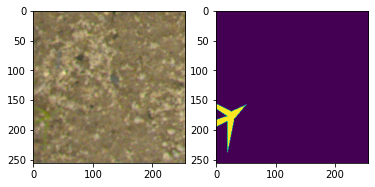

In [ ]:
# Run this cell to visualize augmented image - mask from the dataset

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
print(np.unique(target[0])) # Prints which classes are present inside the augmented image

ax[0].imshow(np.uint8(augmented_img[0]))
ax[1].imshow(np.uint8(target[0,:,:,0]))

plt.show()

# Model creation

## Enc-Dec

In [ ]:
def create_model(depth, start_f, num_classes, dynamic_input_shape): 

    model = tf.keras.Sequential()
    
    # Encoder
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Bottleneck
    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2
        
    # Decoder
    for i in range(depth):
        # the 2 indicates the doubled dim after each iteration
        model.add(tf.keras.layers.UpSampling2D(size = (2,2)))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=3,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
# After many trials, we found that the best hyperparameters were the initial ones:
# depth = 5
# start_f = 16

model = create_model(depth=5, 
                     start_f=16, 
                     num_classes=3, 
                     dynamic_input_shape=False)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
re_lu_23 (ReLU)              (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)       

## Transfer learning (VGG + Decoder)



In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
def create_vgg_model(depth, start_f, num_classes): 
 
    model = tf.keras.Sequential() 
     
    # Encoder 
    model.add(vgg) 
     
    start_f = 256 
         
    # Decoder 
    for i in range(depth): 
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear')) 
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3), 
                                         strides=(1, 1), 
                                         padding='same')) 
        model.add(tf.keras.layers.ReLU()) 
 
        start_f = start_f // 2 
 
    # Prediction Layer 
    model.add(tf.keras.layers.Conv2D(filters=num_classes, 
                                     kernel_size=(1, 1), 
                                     strides=(1, 1), 
                                     padding='same', 
                                     activation='softmax')) 
     
    return model

In [ ]:
'''
model = create_vgg_model(depth=5, 
                         start_f=8, 
                         num_classes = 3)
                         
model.summary()
'''

## uNet-like architecture

In [ ]:
pip install keras-unet

In [ ]:
from keras_unet.models import custom_unet

In [ ]:
'''
model = custom_unet(
    input_shape=(img_w, img_h, 3),
    use_batch_norm=True,
    num_classes=3,
    filters=20,
    dropout=0.2,
    output_activation='softmax')
    '''

"\nmodel = custom_unet(\n    input_shape=(img_w, img_h, 3),\n    use_batch_norm=True,\n    num_classes=3,\n    filters=20,\n    dropout=0.2,\n    output_activation='softmax')"

## Compiling

In [ ]:
# Optimization parameters
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# learning rate
lr = 3e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): 
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      if union == float(0):
        iou = float(1)
      else:
        iou = intersection / union
        
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Tensorboard + Callbacks

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/weeds_localizator/experiments"

In [ ]:
exps_dir = os.path.join('/content/drive/My Drive/weeds_localizator', 'experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Enc-Dec'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', mode = 'max', patience=8, restore_best_weights=True)
    callbacks.append(es_callback)

## Training

In [ ]:
Train_step_size = math.floor(len(train_gen) / bs)

valid_size_multiplier = 1
# If the valid_dataset is big enough, just set this parameter to 1 
# If the valid_dataset is small (it may happen for example when working with just one dataset e.g. 'Bipbip - Haricot') set this parameter to 2, 3, 4, ...
# in this way you validate the model on a number equals to 'valid_size_multiplier' of random crops for each image from the validation dataset.

Valid_step_size = math.floor(valid_size_multiplier * len(valid_gen) / bs)

In [ ]:
history = model.fit(x=train_dataset,
                    epochs=40,
                    steps_per_epoch=Train_step_size,
                    validation_data=valid_dataset,
                    validation_steps=Valid_step_size,
                    callbacks=callbacks)

In [ ]:
# Learning Rate reduction and reset of the optimizer. (Before lr was equal to 5e-4)

lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history2 = model.fit(x=train_dataset,
                    epochs=20,
                    steps_per_epoch=Train_step_size,
                    validation_data=valid_dataset,
                    validation_steps=Valid_step_size,
                    callbacks=callbacks)

In [ ]:
# Best model weights are at the 15° checkpoint

# model.load_weights('/content/drive/My Drive/weeds_localizator/experiments/Enc-Dec_Dec15_15-46-30/ckpts/cp_15.ckpt')

# Testing

## Visualize one prediction

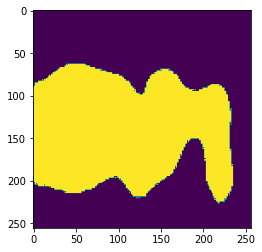

In [ ]:
# Uncomment what you like to see

index_in_batch = 0    # Integer from 0 to bs-1

mask_prova = model.predict(augmented_img)
#plt.imshow(mask_prova[index_in_batch,...,1])                 # Show raw mask
plt.imshow(np.argmax(mask_prova[index_in_batch], axis=-1))   # Show mask
#plt.imshow(np.uint8(augmented_img[index_in_batch]))           # Show image


## Generate '.json' submission file

In [ ]:
# Tiling testing functions

def sum_mask(mask_raw, mask_crop, corner): # Wants np arrays, returns np arrays

  x,y = corner
  y_end = y + mask_crop.shape[0]
  x_end = x + mask_crop.shape[1]
  mask_raw[x:x_end,y:y_end,:] += mask_crop[:,:,:]

  return mask_raw


# 'img' is a PIL Image, out_dim is the dimension of the NN squared input (for ex. out_dim = 256), overlap is in pixel.
# Returns a np.array with the same size of 'img', containing the combined preditions of NN in 'tiling mode' 

def tiling_pred_mask(img, out_dim, overlap, model): 
  w, h = img.size
  corner_list = [] # corners of crops

  # corner generator
  y = 0
  while(True):
    if y + out_dim < h:
      x = 0
      while(True):
        if x + out_dim < w: # image can be still cropped
          corner_list.append([x,y])
          x = x + out_dim - overlap # horizontal shift
        else:
          corner_list.append([w-out_dim, y]) # last
          break # next y
      y = y + out_dim - overlap
    else:
      x = 0
      y = h - out_dim
      while(True):
        if x + out_dim < w: 
          corner_list.append([x,y])
          x = x + out_dim - overlap 
        else:
          corner_list.append([w-out_dim, y])
          break
      break

    mask_raw = np.zeros(shape = (w, h, 3)) # 3 like the number of classes
    for corner in corner_list:
      img_crop = np.array(img.crop((corner[0],corner[1],corner[0]+out_dim,corner[1]+out_dim))) # cropping the image
      img_crop = np.expand_dims(img_crop, 0)
      mask_crop_raw = model.predict(img_crop) # prediction
      mask_crop = mask_crop_raw[0]
      mask_crop = np.transpose(mask_crop, axes = (1,0,2))
      mask_raw = sum_mask(mask_raw, mask_crop, corner) # simple sum, respecting coordinates
    
    # Now, mask_raw contains the sum of all predictions, mapped into the right coordinates
    pred_mask = np.argmax(mask_raw, axis = -1)
    pred_mask = np.transpose(pred_mask, axes = (1,0)) # Transpose axis (because Image -> numpy conversion changed them)

  return pred_mask

In [ ]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# Getting test filepaths

test_filenames = []
for r, d, f in os.walk(dataset_dir + 'Test_Dev'):
    for file in f:
        if('.png' in file or '.jpg' in file):
            test_filenames.append(r + '/' + file)



# Open each image and make the mask prediction

submission_dict = {}
for test_filename in test_filenames:
  team = test_filename.split("/")[-4]
  crop = test_filename.split("/")[-3]
  img_name = (test_filename.split("/")[-1]).split(".")[0]
  
  # Image loading and converting to RGB mode
  img = Image.open(os.path.join(dataset_dir,test_filename)).convert('RGB')

  if tiling:
    pred_mask = tiling_pred_mask(img, img_h, 10, model)
  else:
    img_shape = img.size
    # Resizing it to make it suitable to the model structure
    img = img.resize((img_h,img_w))
    img_array = np.array(img)
    out_sigmoid = model.predict(x=tf.expand_dims(img_array, 0)) 
    pred_mask = tf.argmax(out_sigmoid, axis=-1)
    pred_mask = pred_mask[0, ...]
    pred_mask = np.array(pred_mask)
    
  submission_dict[img_name] = {}
  submission_dict[img_name]['shape'] = pred_mask.shape
  submission_dict[img_name]['team'] = team
  submission_dict[img_name]['crop'] = crop
  submission_dict[img_name]['segmentation'] = {}

  # RLE encoding
  # crop
  rle_encoded_crop = rle_encode(pred_mask == 1)
  # weed
  rle_encoded_weed = rle_encode(pred_mask == 2)

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed



# Generate .json file

result_file = 'result_' + datetime.now().strftime('%b%d_%H-%M-%S') + '.json'
with open(os.path.join(cwd, '/content/drive/My Drive/weeds_localizator/results/' + result_file), 'w') as f:
    json.dump(submission_dict, f)